# Venus Atmospheric Modelling - Entry to Flight (Conceptual)
The Open University<br>
Module SXS841 Masters level project in physical sciences<br>
***
End of Module Assignment (EMA) 01<br>
Stuart Gavin Smith<br>
H1872126<br>
25 August 2025<br>
Version:1.0 (Final for Report)<br>
***

In [1]:
#%%capture cap
#Comment out the above line to view text in the output

#Note:
#
#Specific equations that are not standard shape/volume, speed/distance, trigonometry, Pythagoras etc.
#are highlighted on frist use in the code with: 
#
######### EQUATION (Eq. X)                                
#
#These equations are then more fully expanded on in the notes.


import io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import *
from scipy import interpolate
from scipy.interpolate import interp1d
import datetime

#Ignore deprecated function on data frame append
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

#Use the data created in the atmospheric modelling 
ATM_CSV = r'C:\Users\stuar\OneDrive\Open University\SXS841\Venus Atmospheric Modelling\CSV_Exports\dfALT_D.csv'
ATP_CSV = r'C:\Users\stuar\OneDrive\Open University\SXS841\Venus Atmospheric Modelling\CSV_Exports\dfALT_T.csv'
APR_CSV = r'C:\Users\stuar\OneDrive\Open University\SXS841\Venus Atmospheric Modelling\CSV_Exports\dfALT_P.csv'

#Read CSV data into dataframe, on error, print warning and stop kernel.
try:
    dfA=read_csv(ATM_CSV, skiprows=1,names=['ALT-KM','RHO-KG-M3'])
except:
    print("ATM_CSV Venus data does not exist, or some other error")
    Error = True
    exit()

#Read CSV data into dataframe, on error, print warning and stop kernel.
try:
    dfT=read_csv(ATP_CSV, skiprows=1,names=['ALT-KM','T-DEG-K','T-DEG-C'])
except:
    print("ATP_CSV Venus data does not exist, or some other error")
    Error = True
    exit()

#Read CSV data into dataframe, on error, print warning and stop kernel.
try:
    dfP=read_csv(APR_CSV, skiprows=1,names=['ALT-KM','P-BARS'])
except:
    print("APR_CSV Venus data does not exist, or some other error")
    Error = True
    exit()
    
#Convert KM to metres
dfA['ALT-KM'] = dfA['ALT-KM'] * 1000.0
dfT['ALT-KM'] = dfT['ALT-KM'] * 1000.0
dfP['ALT-KM'] = dfP['ALT-KM'] * 1000.0

#Sort original data for plotting
dfA.sort_values("ALT-KM", ascending=True)
dfT.sort_values("ALT-KM", ascending=True)
dfP.sort_values("ALT-KM", ascending=True)

#Model Constants
maxmetres = 200000 # model start altitude, 10km above interface

# Constants - Venus
g    = 8.87    # m/s^2 Venus acceleration due to gravity at surface 
gE   = 9.81    # m/s^2 Earth acceleration due to gravity at surface 
R    = 6051800 # m Planetary equatorial mean radius of Venus
RHOs = 65      # kg/m^3 Atmospheric density at sea level 
Hs   = 15819   # m Venus atmospheric scale height

#Constants - Conceptual Entry Probe

Rnose = 1.7 / 2.0 # m radius of Entry Probe at base
Reff  = 0.40      # m effectice nose radius of Probe for entry heating 

CD   = 1.05  # Drag coefficient for a blunted cone
CDd  = 0.816 # Drag coefficient for the drogue chute (from Blue Book)
CDs  = 0.47  # Drag coefficient for a sphere 
CDp  = 0.543 # Drag coefficient for Conceptual Vehicle based on Venus Pioneer Large Probe (from Blue Book)
CDb  = 0.47  # Drag coefficient for a baloon, assume spherical inflation from centre of sphere (simplified)
CDgp = 1.17  # Drag coefficient for a flat disc representing the Gondola and probe structure once heat shield ejected

EntryProbeDiameter    = 1.7 # m Diamater of Entry Probe (bunted cone)
DrogueChuteDiameter   = 1.0 # m Diameter of drogue parachute
MainChuteDiameter     = 7.0 # m Diameter of main parachute
BalloonDesignDiameter = 6.0 # m Design diameter of balloon

BalloonVolumeFull = (4.0/3.0)*np.pi*np.power(BalloonDesignDiameter/2.0,3) # m^3 volume of balloon

S  = np.pi*(Rnose*Rnose)                                             # m^2 Cross-sectional area of entry probe
Sd = np.pi*((EntryProbeDiameter/2.0)*(EntryProbeDiameter/2.0))       # m^2 Cross-sectional area drogue chute
Sp = np.pi*((MainChuteDiameter/2.0)*(MainChuteDiameter/2.0))         # m^2 Cross-sectional area main parachute
Sb = np.pi*((BalloonDesignDiameter/2.0)*(BalloonDesignDiameter/2.0)) # m^2 Cross-sectional area balloon

m                        = 943.55                 # kg Entry Probe all up mass 
mPayloadAndBalloonAndGas = 104.25                 # kg Gondola mass
mGasCylinders            = 480.0 + 114.90 + 7.88  # kg Gas cylinders, inflation and release mechanism mass
mBackShell               = 44.12 + 3.94 + 20.0    # kg Backshell and release mechanism mass
mHeatShield              = 140.0 + 3.94           # kg Heat shield and release mechanism mass
mDrogueChute             = 4.33                   # kg Drogue chute, tehering and release mechanism mass
mMainParachute           = 20.19                  # kg Main chute, tethering and release mechanism mass

y0 = 45.00  # Degrees entry angle 
Ve = 11540  # m/s entry velocity  
h  = 160000 # m height of atmospheric interface (from surface)
r  = R + h  # m height of atmoshperic interface from planetary centre

#Constants - Parachute inflation speed (maximum)
InflateDrogueChuteMach = 2.0 # Mach (Venus)
InflateMainChuteMach   = 1.0 # Mach (Venus)

#Maximum altitude to inflate balloon and operational altitude 
InflateBalloonAlt   = 65000 # m
OperationalAltitude = 50500 # m

#Timing for balloon inflation
sBalloonInflationTime = 423.0 # seconds

#Altitude where drag force is dominant over gravity, high alitutude model 'protection'
DominantAltitudeProtection = 75000 # m 

#Inflate balloon when the horizontal velocity reaches the predicted windspeed of 60-70 m/s 
#for a lower cloud base altitude (47 km) - from Sánchez-Lavega, A., Hueso, R., Piccioni, G., 
#Drossart, P., Peralta, J., Pérez-Hoyos, S., Wilson, C. F., Taylor, F. W., Baines, K. H., 
#Luz, D., Erard, S., & Lebonnois, S. (2008). Variable winds on Venus mapped in three 
#dimensions. Geophysical Research Letters, 35(13). https://doi.org/10.1029/2008GL033817
HorizontalVelocityMax = 65.0 # m/s

#Maximum number of model step iterations
aMaxMS = 5000000
  
#Set the step resoluton and initial altitude     
StepResolutionCalc = 1000.0 # milliseconds
StepResolutionOut  = 1000.0 # milliseconds

print("====================================SIMULATION CONFIGURATION======================================")
print("")
print("= Drag Co-Efficients and Cross Sectional Area")
print("")
print("Probe CD (coef.drag)  : " + f'{CD:10.2f}' )
print("Probe S (X section)   : " + f'{S:10.2f}' + str(' m2'))
print("Drogue Chute CDd      : " + f'{CDd:10.2f}' )
print("Drogue Chute Sd       : " + f'{Sd:10.2f}' + str(' m2'))
print("Main Parachute CDp    : " + f'{CDp:10.2f}' )
print("Main Parachute Sp     : " + f'{Sp:10.2f}' + str(' m2'))
print("Balloon CDb           : " + f'{CDb:10.2f}' )
print("Balloon Sb            : " + f'{Sb:10.2f}' + str(' m2'))
print("")
print("= Dimensions")
print("")
print("Entry Probe Diameter  : " + f'{EntryProbeDiameter:10.2f}'+ str(' m'))
print("Effective Nose Radius : " + f'{Reff:10.2f}'+ str(' m2'))
print("Balloon Diameter      : " + f'{BalloonDesignDiameter:10.2f}'+ str(' m'))
print("Balloon Volume        : " + f'{BalloonVolumeFull:10.2f}' + str(' m3'))
print("Main Chute Diameter   : " + f'{MainChuteDiameter:10.2f}'+ str(' m'))
print("Drogue Chute Diameter : " + f'{DrogueChuteDiameter:10.2f}' + str(' m'))
print("")
print("= Mass")
print("")
print("Probe Mass            : " + f'{m:10.2f}' + str(' kg'))
print("Payload, Bal./Gas Mass: " + f'{mPayloadAndBalloonAndGas:10.2f}' + str(' kg'))
print("Gas Cylinder Mass     : " + f'{mGasCylinders:10.2f}' + str(' kg'))
print("Back Shell Mass       : " + f'{mBackShell:10.2f}' + str(' kg'))
print("Heat Shield Mass      : " + f'{mHeatShield:10.2f}' + str(' kg'))
print("Drogue Chute Mass     : " + f'{mDrogueChute:10.2f}' + str(' kg'))
print("Main Parachute Mass   : " + f'{mMainParachute:10.2f}' + str(' kg'))
print("")
print("= Ballistic Entry Characteristics")
print("")
print("Entry Angle           : " + f'{y0:10.2f}' + str(' degrees'))
print("Entry Velocity        : " + f'{Ve:10.2f}' + str(' m/s'))
print("Start Altitude        : " + f'{maxmetres:10.2f}' + str(' m'))
print("")
print("= Atmospheric and Planetary")
print("")
print("Atmosphere Interface  : " + f'{h:10.2f}' + str(' m'))
print("Scale Height          : " + f'{Hs:10.2f}' + str(' m'))
print("Gravity Venus Surface : " + f'{g:10.2f}' + str(' m/s/s'))
print("Equatorial Mean Radius: " + f'{R:10.2f}' + str(' m'))
print("")
print("= Simulation Events")
print("")
print("Deploy Drogue Velocity: " + f'{InflateDrogueChuteMach:10.2f}' + str(' Mach'))
print("Deploy Para. Velocity : " + f'{InflateMainChuteMach:10.2f}' + str(' Mach'))
print("Time to Inflate Ball. : " + f'{sBalloonInflationTime:10.2f}' + str(' seconds'))
print("Max Vel.Horiz. Ball.  : " + f'{HorizontalVelocityMax:10.2f}' + str(' m/s'))
print("Operational Altitude  : " + f'{OperationalAltitude:10.2f}' + str(' m'))
print("Max Simluation Steps  : " + f'{aMaxMS:10.2f}' + str(' steps'))
print("Step Resolution       : " + f'{StepResolutionCalc:10.2f}' + str(' [1000 = 1 second]'))
print("")


#Arrays to hold the atmospheric measurement models of Density and Temperature
densityX = np.linspace(0,maxmetres,maxmetres)
densityY = np.arange(maxmetres,dtype=float)
tempX = np.linspace(0,maxmetres,maxmetres)
tempY = np.arange(maxmetres,dtype=float)
pressureX = np.linspace(0,maxmetres,maxmetres)
pressureY = np.arange(maxmetres,dtype=float)
densityY2 = np.arange(maxmetres,dtype=float)

# Function to find the nearest density value in the dataframe
def find_nearest_density(df, AltCol, DenCol, value):
    arrayalt = df[AltCol].values
    arrayrho = df[DenCol].values
    idx = (np.abs(arrayalt - (1.0*value))).argmin()
    return arrayrho[idx]

# Function to find the nearest temperature value in the dataframe
def find_nearest_temp(df, AltCol, TempCol, value):
    arrayalt = df[AltCol].values
    arraydegC = df[TempCol].values
    idx = (np.abs(arrayalt - (1.0*value))).argmin()
    return arraydegC[idx]

# Function to find the nearest pressure value in the dataframe
def find_nearest_pressure(df, AltCol, PressCol, value):
    arrayalt = df[AltCol].values
    arrayBars = df[PressCol].values
    idx = (np.abs(arrayalt - (1.0*value))).argmin()
    return arrayBars[idx]

# Create a 1m density height model from measurements
for AltCount in range(maxmetres):
    nearest_density = find_nearest_density(dfA, 'ALT-KM', 'RHO-KG-M3',AltCount)
    densityY[AltCount] = nearest_density

# Create a 1m temperature height model from measurements
for AltCount in range(maxmetres):
    nearest_temp = find_nearest_temp(dfT, 'ALT-KM', 'T-DEG-C',AltCount)
    tempY[AltCount] = nearest_temp

# Create a 1m pressure height model from measurements
for AltCount in range(maxmetres):
    nearest_pressure = find_nearest_pressure(dfP, 'ALT-KM', 'P-BARS',AltCount)
    pressureY[AltCount] = nearest_pressure

#From mathematical means, create an atmosphere model for validation purposes
for AltCount in range(maxmetres):
    #ρ = ρ0 exp ( -h / H )
    densityY2[AltCount] = RHOs * np.exp(-(AltCount/Hs))

# Interpolate the 'step' changes to increase fidelity to 1m steps    
Y1 = densityY[0]
Y2 = 0.0
X1 = 0
X2 = 0

#For each metre of height, smooth (simple interpolation)
for AltCount in range(maxmetres):
    if Y1 != densityY[AltCount]:
        #A step change has been detected
        X2 = AltCount - 1
        Y2 = densityY[AltCount]

        #Calculate the scaling factor to apply (interpolate)
        Yfactor = (Y2-Y1)/(X2-X1+1)
        
        #Now interpolate between the 2 points
        for InterpCount in range(X2-X1+1):
            densityY[int(X1+InterpCount)] = Y1 + (Yfactor*InterpCount)
        
        #Start a new step 
        Y1 = densityY[AltCount]
        X1 = AltCount

# Interpolate the 'step' changes to increase fidelity to 1m steps    
Y1 = tempY[0]
Y2 = 0.0
X1 = 0
X2 = 0

#For each metre of height, smooth (simple interpolation so each metre of height has a value)
for AltCount in range(maxmetres):
    if Y1 != tempY[AltCount]:
        #A step change has been detected
        X2 = AltCount - 1
        Y2 = tempY[AltCount]

        #Calculate the scaling factor to apply (interpolate)
        Yfactor = (Y2-Y1)/(X2-X1+1)
        
        #Now interpolate between the 2 points
        for InterpCount in range(X2-X1+1):
            tempY[int(X1+InterpCount)] = Y1 + (Yfactor*InterpCount)
        
        #Start a new step 
        Y1 = tempY[AltCount]
        X1 = AltCount        

# Interpolate the 'step' changes to increase fidelity to 1m steps    
Y1 = pressureY[0]
Y2 = 0.0
X1 = 0
X2 = 0

#For each metre of height, smooth (simple interpolation so each metre of height has a value)
for AltCount in range(maxmetres):
    if Y1 != pressureY[AltCount]:
        #A step change has been detected
        X2 = AltCount - 1
        Y2 = pressureY[AltCount]

        #Calculate the scaling factor to apply (interpolate)
        Yfactor = (Y2-Y1)/(X2-X1+1)
        
        #Now interpolate between the 2 points
        for InterpCount in range(X2-X1+1):
            pressureY[int(X1+InterpCount)] = Y1 + (Yfactor*InterpCount)
        
        #Start a new step 
        Y1 = pressureY[AltCount]
        X1 = AltCount        
    
#Set the 1st step conditions
Alt                  = maxmetres - 1
gh                   = g
Vcurrent             = Ve
aStep                = 0.0
Acc                  = 0.0
Drag                 = 0.0
AngleD               = 0.0
VerticalD            = 0.0
VerticalDstep        = 0.0
HorizontalD          = 0.0
VerticalV            = 0.0
HorizontalV          = 0.0
RHOmd                = 0.0
Tempmd               = 0.0
Pressuremd           = 0.0
TotalHeatLoad        = 0.0
qDotms               = 0.0
AscentRate           = 0.0
BalloonVolumeCurrent = 0.0
BalloonDiameter      = 0.0
Mach                 = 0.0

#Set the flags
DrogueChuteDeployed = False
DrogueChuteInflated = False
ParachuteDeployed   = False
ParachuteInflated   = False
BalloonDeployed     = False
BalloonInflated     = False
GravityDominant     = False
DragisZero          = False
GravGreaterThanDrag = False

#Convert entry angle to radians
gammaR = np.radians(y0)

#Create step model data frame to store step data
dfStepModel = DataFrame(columns=['TimeMS','Alt','Acc','Drag','Velocity','VerticalV','HorizontalV','HorizontalD', 'VerticalD', 'AngleD', 'Density', 'Temperature', 'Pressure', 'qDot', 'AscentRate', 'Mach'])

#Atmospheric Model or Measurement Basis? True = use Pioneer Venus measured data (M), False = Scale Height (S)
UseMeasurements = True

#Peak Values and Time Markers
PeakAcc                = 0.0
PeakAccTimeStep        = 0.0
PeakAccAltitude        = 0.0
PeakHeatFlux           = 0.0
PeakHeatFluxTimeStep   = 0.0
PeakHeatFluxAltitude   = 0.0
PeakTemp               = -273.15
PeakTempTimeStep       = 0.0
PeakDensity            = 0.0
PeakDensityTimeStep    = 0.0
LowestAltitude         = Alt
LowestAltitudeTimeStep = 0.0
print("")
print("========================================SIMULATION START==========================================")
print("")
print("Time s    │Altitude m│B.Vol. m^3│B.Dia. m  │Ascent m/s│Vel. m/s  │Mach      │Acc. g    │gh ms^2")
print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")      
#Record real model start time            
StartTimeDate = datetime.datetime.now()

#Create the step model with ms loop counter representing time
msCount = 0
while msCount < aMaxMS:

    #Exit if we hit the ground !
    if Alt <= 0:
        print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                                      
        print(f'{msCount/StepResolution:10.2f}'+ ' Hit ground, model stopping')        
        Alt = 0
        break;
        
    #Exit if velocities go below ZERO past the atmospheric interface before balloon deployed
    if Vcurrent <= 0 and Alt <= h and BalloonDeployed == False:
        print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                                      
        print(f'{msCount/StepResolutionOut:10.2f}'+ ' Negative Velocity Vcurrent')
        print(f'{msCount/StepResolutionOut:10.2f}'+ ' Velocity Vcurrent: ' + str(Vcurrent))
        print(f'{msCount/StepResolutionOut:10.2f}'+ ' Velocity Vvert: ' + str(VerticalV))
        print(f'{msCount/StepResolutionOut:10.2f}'+ ' Velocity Vhoriz: ' + str(HorizontalV))
        Alt = 0
        break;
    if VerticalV <= 0 and Alt <= h and BalloonDeployed == False:
        print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                                      
        print(f'{msCount/StepResolutionOut:10.2f}'+ ' Negative Velocity Vvert')
        print(f'{msCount/StepResolutionOut:10.2f}'+ ' Velocity Vcurrent: ' + str(Vcurrent))
        print(f'{msCount/StepResolutionOut:10.2f}'+ ' Velocity Vvert: ' + str(VerticalV))
        print(f'{msCount/StepResolutionOut:10.2f}'+ ' Velocity Vhoriz: ' + str(HorizontalV))
        Alt = 0
        break;
    if HorizontalV <= 0 and Alt <= h and BalloonDeployed == False:
        print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                                      
        print(f'{msCount/StepResolution:10.2f}'+ ' Negative Velocity Vhoriz')
        print(f'{msCount/StepResolution:10.2f}'+ ' Velocity Vcurrent: ' + str(Vcurrent))
        print(f'{msCount/StepResolution:10.2f}'+ ' Velocity Vvert: ' + str(VerticalV))
        print(f'{msCount/StepResolution:10.2f}'+ ' Velocity Vhoriz: ' + str(HorizontalV))
        Alt = 0
        break;

    # Calculate acceleraton due to gravity for given height gh
    gh = g * np.power((R / (R + Alt)),2)
    ################### EQUATION (Eq. 1)
    
    #calculate the velocity and displacement in the horizontal and vertical at end of step  
    if BalloonDeployed == True:
        #Use aerostatic physics
        
        #Increment millisecond counter by 1 second per iteration
        msCount = msCount + 1000
        
        #Assume Velocity along flight path has been 'scrubbed' to near zero by the drag forces, now the balloon 
        #is being inflated and will start to rise once sufficient lifting gas provides a positive ascent rate
        
        #Drag still exists, slowing vehicle against pull of gravity, co-efficient assume for flat disc
        #now heat shield ejected, balloon would add additional drag, but simplification it is not modelled.
        Drag = 0.5 * RHOmd * np.power(VerticalV, 2) * CDgp * S
        ##################################### EQUATION (Eq. 2)        
        AccDrag = Drag / m
        # EQUATION (Eq. 3)        
        
        #Vertical velocity is gravity (positive down), drag (negative up) and ascent (negative up)
        if AscentRate > 0.0:
            #Rising
            VerticalV = -1.0 * AscentRate #/ StepResolution
        else:
            #Falling
            VerticalV = VerticalV + (gh / StepResolutionCalc) - (AccDrag / StepResolutionCalc)

        #Vertical Distance is total distance moved (up and down)
        VerticalD = VerticalD + abs(VerticalV / StepResolutionCalc)
        
        #Negative VerticalDstep means balloon is rising (used for altitude)
        VerticalDstep = (VerticalV / StepResolutionCalc)
        
        #The vertical velocity will be impacted by gravity, lift and drag forces. Horizontal by wind speed
        #and velocity is 2-D resultant of the horizontal and vertical components. 
        HorizontalV = HorizontalVelocityMax
        HorizontalD = HorizontalD + (HorizontalVelocityMax / StepResolutionCalc)
        Vcurrent = np.sqrt((VerticalV * VerticalV) + (HorizontalV * HorizontalV))
        AngleD = AngleD + (Vcurrent / StepResolutionCalc)
        
        #Calculate the exit altitude
        Alt = Alt - VerticalDstep

    else:
        # use ballistic entry physics
        AngleD = AngleD + (Vcurrent / StepResolutionCalc)
        VerticalDstep = abs((np.sin(gammaR) * (Vcurrent / StepResolutionCalc)))
        VerticalD = VerticalD + abs((np.sin(gammaR) * (Vcurrent / StepResolutionCalc)))
        HorizontalD = HorizontalD + (np.cos(gammaR) * (Vcurrent / StepResolutionCalc))
        VerticalV = np.abs(np.sin(gammaR) * Vcurrent)
        HorizontalV = np.abs(np.cos(gammaR) * Vcurrent)

    #Protect atmosphere model 
    if Alt >= maxmetres:
        print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                                      
        print(f'{msCount/StepResolutionOut:10.2f}'+ ' Altitude exceeds atmosphere, model stopping')               
        Alt = maxmetres - 1
        break;

    #Get the density of air for this altitude using measurements or calculate from equation
    if UseMeasurements == True:
        RHOmd = densityY[int(Alt)]
    else:
        RHOmd = densityY2[int(Alt)]
        
    #Get the temperature for this altitude
    Tempmd = tempY[int(Alt)]
    
    #Get the pressure for this altitude
    Pressuremd = pressureY[int(Alt)]
    
    #Calculate the Mach number for this altitude, where c is speed of sound, k = ratio of specific heats (adiabatic index),
    # R = individual gas constant(J/kg K) and T = temperature in Kelvin
    # c = (k R T)^0.5
    # Venus is ~97% carbon dioxide, assume k = 1.28 and 188.92 J/kg K
    Mach = np.power((1.28 * 188.92 * (Tempmd+273.15)),0.5)
    ##################################### EQUATION (Eq. 4)            
    
    # Limit Mach between 0.0 and 410 m/s (the known maximum of Mach in Venus)
    if Mach < 0.0:
        Mach = 0.0
    if Mach > 410.0:
        Mach = 410.0
        
    #Calculate the drag force of the main probe (without drogue or main chute) - assume constant CD and S 
    #even with jettison of backshell, heatshield and cylinders - simplification
    Drag = 0.5 * RHOmd * np.power(Vcurrent, 2) * CD * S

    #Adjust co-efficients, mass and cross-sectional areas for deployment events
    if Alt < InflateBalloonAlt and HorizontalV <= HorizontalVelocityMax:

        if BalloonInflated == False:
            #Simplification, volume increases in a linear fashion due to constant flow rate from cylinders
            #use this to determine diameter to put into ascent rate equation, flow rate based on calculation
            #of valve flow rate and initial mass (see report - only an approximation as valve rates can
            #be designed for a specific rate).
            BalloonVolumeRate = BalloonVolumeFull / (sBalloonInflationTime * StepResolutionCalc)
            BalloonVolumeCurrent = BalloonVolumeCurrent + BalloonVolumeRate

            #Calculate diameter of balloon (equivalent lifting sphere)
            BalloonDiameter = np.cbrt((6*BalloonVolumeCurrent)/np.pi)

            #Balloon cannot inflate beyond its design diameter
            if BalloonDiameter >= BalloonDesignDiameter:
                BalloonDiameter = BalloonDesignDiameter
                BalloonInflated = True
                #Baloon inflated, reduce mass by jettisoning the gas cylinders (expect ascent rate to soar)
                m = m - mGasCylinders 
                print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                                              
                print(f'{msCount/StepResolutionOut:10.2f}'+ ' Cylinders released')            
                print(f'{msCount/StepResolutionOut:10.2f}'+ ' Mass change, mass now: ' + f'{m:04.3f}' + str(' kg'))
                print(f'{msCount/StepResolutionOut:10.2f}'+ ' Balloon inflated')    
                print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                                              

            #Calculate current density of helium, Ambient Pressure Pa  / (Temperature K * He Gas Constant)
            RHOHe = (Pressuremd * 100000) / ((Tempmd + 273.15) * 2077.1)
            ########################################### EQUATION (Eq. 5)                        

            #Ascent rate goes positive when the balloon generates more lift than the mass
            try:
                #if the top line of this equation is negative, do not complete the sqrt
                if 8 * gh * ( ( (RHOmd - RHOHe) * ( ( np.pi*np.power(BalloonDiameter,3) ) / 6 ) ) - m ) < 0.0:
                    AscentRate = 0.0
                else:
                    AscentRate = np.sqrt((8 * gh * ( ( (RHOmd - RHOHe) * 
                                          ( ( np.pi*np.power(BalloonDiameter,3) ) / 6 ) ) - m ) ) 
                                         / ( CDb*RHOmd*np.pi*np.power(BalloonDiameter,2) ) )
                    ############################################################ EQUATION (Eq. 6)            
            except:
                AscentRate = 0.0  # Handle the error by assigning a default value

            #Check value is a number
            if np.isnan(AscentRate):
                AscentRate = 0.0
        else:

            #Stop model, at ascent rate nearing zero (equilibirum)
            if AscentRate < 0.1: 
                print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                                              
                print(f'{msCount/StepResolutionOut:10.2f}'+ ' Ascent Rate nearing ZERO - model stopping')            
                break;

            #Ascend until operational altitude reached
            if Alt > OperationalAltitude: 
                #Stop model, at altitude
                print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                              
                print(f'{msCount/StepResolutionOut:10.2f}'+ ' Operational Altitude Reached - model stopping')            
                break;
            else:
                #Keep ascending
                BalloonDiameter = BalloonDesignDiameter

                #Calculate current density of helium, Ambient Pressure Pa  / (Temperature K * He Gas Constant)
                RHOHe = (Pressuremd * 100000) / ((Tempmd + 273.15) * 2077.1)

                #Ascent rate goes positive when the balloon generates more lift than the mass
                try:
                    #if the top line of this equation is negative, do not complete the sqrt
                    if 8 * gh * ( ( (RHOmd - RHOHe) * ( ( np.pi*np.power(BalloonDiameter,3) ) / 6 ) ) - m ) < 0.0:
                        AscentRate = 0.0
                    else:
                        AscentRate = np.sqrt((8 * gh * ( ( (RHOmd - RHOHe) * 
                                              ( ( np.pi*np.power(BalloonDiameter,3) ) / 6 ) ) - m ) ) 
                                             / ( CDb*RHOmd*np.pi*np.power(BalloonDiameter,2) ) )
                except:
                    AscentRate = 0.0  # Handle the error by assigning a default value
            
                #Check valus is a number
                if np.isnan(AscentRate):
                    AscentRate = 0.0

        if BalloonDeployed == False:
            #Eject the chutes
            m = m - mDrogueChute - mMainParachute
            print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                  
            print(f'{msCount/StepResolutionOut:10.2f}'+ ' Chutes released')                        
            print(f'{msCount/StepResolutionOut:10.2f}'+ ' Mass change, mass now: ' + f'{m:04.3f}' + str(' kg'))
            print(f'{msCount/StepResolutionOut:10.2f}'+ ' Balloon inflating') 
            print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                              

            #Change to a 1 second model
            StepResolutionCalc = 1.0

            #Flag balloon deployed
            BalloonDeployed = True                    

    #Adjust for main parachute 
    elif Vcurrent < (InflateMainChuteMach * Mach):
        if ParachuteDeployed == False:
            print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                  
            print(f'{msCount/StepResolutionOut:10.2f}'+ ' Main Parachute deployed')            
            ParachuteDeployed = True

            #Time to open diameter / opening airspeed - approximation (Lund et. al.) 
            sParachuteInflationTime = MainChuteDiameter / Vcurrent
            ##################################### EQUATION (Eq. 7)                        
            print(f'{msCount/StepResolutionOut:10.2f}'+ ' Chute inflation time: ' + f'{sParachuteInflationTime:04.3f}' + str(' s'))            
            print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                              
            
            #Inflation start time
            InflationStartTime = msCount
            
            #Inflation modelled as increasing drag as surface area increases (crude linear approximation)
            SFactor = Sp / (sParachuteInflationTime * StepResolutionCalc)
            lclSp = 0.0001 #small, but not ZERO
        
        if msCount < (InflationStartTime + (sParachuteInflationTime * StepResolutionCalc)):
            #increasing cross sectional area as it inflates over the msParachuteInflationTime steps
            lclSp = lclSp + SFactor
        else:
            if ParachuteInflated == False:
                ParachuteInflated = True
                #Reduce mass by jettisoning the heat shield
                m = m - mHeatShield 
                print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                  
                print(f'{msCount/StepResolutionOut:10.2f}'+ ' Heat Shield released')            
                print(f'{msCount/StepResolutionOut:10.2f}'+ ' Mass change, mass now: ' + f'{m:04.3f}' + str(' kg'))
                print(f'{msCount/StepResolutionOut:10.2f}'+ ' Main Parachute inflated')            
                print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                  
                lclSd = Sp
            
        #Add additional drag for the main parachute on top of the drogue
        DragParachute = 0.5 * RHOmd * np.power(Vcurrent, 2) * CDp * lclSp
        DragDrogue = 0.5 * RHOmd * np.power(Vcurrent, 2) * CDd * Sd
        Drag = Drag + DragDrogue + DragParachute 

    #Adjust for drogue chute
    elif Vcurrent < (InflateDrogueChuteMach * Mach):
        if DrogueChuteDeployed == False:
            #Reduce mass by jettisoning the backshell covering the drogue chute
            m = m - mBackShell
            print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                              
            print(f'{msCount/StepResolutionOut:10.2f}'+ ' Back Shell released')            
            print(f'{msCount/StepResolutionOut:10.2f}'+ ' Mass change, mass now: ' + f'{m:04.3f}' + str(' kg'))
            print(f'{msCount/StepResolutionOut:10.2f}'+ ' Drogue Chute deployed')            
            DrogueChuteDeployed = True
            
            #Time to open diameter / opening airspeed - approximation (Lund et. al.) 
            sDrogueChuteInflationTime = DrogueChuteDiameter / Vcurrent
            print(f'{msCount/StepResolutionOut:10.2f}'+ ' Drogue inflation time: ' + f'{sDrogueChuteInflationTime:04.3f}' + str(' s'))
            print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                          
            
            #Inflation start time
            InflationStartTime = msCount
            
            #Inflation modelled as increasing drag as surface area increases (crude linear approximation)
            SFactor = Sd / (sDrogueChuteInflationTime * StepResolutionCalc)
            lclSd = 0.0001 #small, but not ZERO
        
        if msCount < (InflationStartTime + (sDrogueChuteInflationTime * StepResolutionCalc)):
            #increasing cross sectional area over the msDrogueChuteInflationTime steps
            lclSd = lclSd + SFactor
        else:
            if DrogueChuteInflated == False:
                DrogueChuteInflated = True
                print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                              
                print(f'{msCount/StepResolutionOut:10.2f}'+ ' Drogue Chute inflated')                            
                print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                                              
                lclSd = Sd
           
        #Add additional drag for the drogue chute
        DragDrogue = 0.5 * RHOmd * np.power(Vcurrent, 2) * CDd * lclSd
        Drag = Drag + DragDrogue
    
    #Calculate entry forces, velocities and other data based on craft configuration, and drag
    if BalloonDeployed == False:

        #Use ballistic entry physics
    
        #Calculate gravitational force (at angle) acting on the trajectory velocity along path of entry
        GravForce = m * (gh / np.sin(gammaR))

        #Protect against high atmosphere where gravity is dominant 
        if GravForce > Drag and Alt < DominantAltitudeProtection:
            #Gravity becoming dominant 
            if GravityDominant == False:
                GravityDominant = True
                print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                                              
                print(f'{msCount/StepResolutionOut:10.2f}'+ ' Gravity dominant force')
                print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                                              

        #Calculate the deceleration (F = ma) adjusting drag for gravity along the path of entry 
        if Drag < GravForce or Drag < 0.0:

            #Protect against anomalies
            if Drag < 0.0:
                #Drag should not be negative in this model until exited the entry flight path and in balloon physics
                if DragisZero == False:
                    DragisZero = True;
                    print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                                                      
                    print(f'{msCount/StepResolution:10.2f}'+ ' Drag negative, Gravity Force: ' + f'{GravForce:.2f}' + ' N')
                    print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                                                  
                Acc = GravForce / m
            else:
                #Gravity is the dominant force 
                if GravGreaterThanDrag == False and Alt < DominantAltitudeProtection:
                    GravGreaterThanDrag = True
                    print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                                                  
                    print(f'{msCount/StepResolutionOut:10.2f}'+ ' Gravity > Drag')
                    print(f'{msCount/StepResolutionOut:10.2f}'+ ' Drag Force: ' + f'{Drag:.2f}' + ' N')
                    print(f'{msCount/StepResolutionOut:10.2f}'+ ' Gravity Force: ' + f'{GravForce:.2f}' + ' N')
                    print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")                                                                  
                Acc = (Drag - GravForce) / m
        else:
            #Acceleration adjusted for effect of gravity 
            Acc = (Drag - GravForce) / m

        #Calculate the heating rate (Watts per cm2)
        qDot = (1.8960e-4 * np.power(Vcurrent,3) * np.sqrt(RHOmd/Reff)) / 10000.0
        ######################################################### EQUATION (Eq. 8)                                

        #Total heat load is measured in Joules - adjust summing according to resolution 
        qDotms = qDot / StepResolutionCalc
        TotalHeatLoad = TotalHeatLoad + qDotms        

        #Calculate the exit altitude
        Alt = Alt - VerticalDstep

        #Calculate the exit velocity along the path of entry of this step, decceleration acts over 1m-ms/1m-ms
        #Positive Acc is decelerating effects, once gravity kicks in, it will turn negative
        Vcurrent = Vcurrent - (Acc / StepResolutionCalc)
    
    #Store the step output states
    stepData = {'TimeMS'      :msCount,
                'Alt'         : Alt,
                'Acc'         : Acc,
                'Drag'        : Drag,
                'Velocity'    : Vcurrent,
                'VerticalV'   : VerticalV,
                'HorizontalV' : HorizontalV,
                'HorizontalD' : HorizontalD,
                'VerticalD'   : VerticalD,
                'AngleD'      : AngleD,
                'Density'     : RHOmd,
                'Temperature' : Tempmd,
                'Pressure'    : Pressuremd,
                'qDot'        : qDot,
                'AscentRate'  : AscentRate,
                'Mach'        : Mach}
    dfStepModel = dfStepModel.append(stepData, ignore_index=True)

    #Store peak values and timestamps
    if PeakAcc < Acc:
        PeakAcc = Acc
        PeakAccTimeStep = msCount
        PeakAccAltitude = Alt

    if PeakHeatFlux < qDot:
        PeakHeatFlux = qDot
        PeakHeatFluxTimeStep = msCount
        PeakHeatFluxAltitude = Alt
        
    if PeakTemp < Tempmd:
        PeakTemp = Tempmd
        PeakTempTimeStep = msCount
        
    if PeakDensity < RHOmd:
        PeakDensity = RHOmd
        PeakDensityTimeStep = msCount

    if LowestAltitude > Alt:
        LowestAltitude = Alt
        LowestAltitudeTimeStep = msCount
    
    #Comfort Message whilst processing and some critical model data
    if BalloonDeployed == True:
        # Every 50 seconds for balloon physics
        if msCount % (50) == 0:
            print(f'{msCount/StepResolutionOut:10.2f}' + '│'  
                + f'{Alt/1000:10.2f}' + '│'  
                + f'{BalloonVolumeCurrent:10.2f}' + '│'  
                + f'{BalloonDiameter:10.2f}' + '│'  
                + f'{AscentRate:10.2f}' + '│'  
                + f'{Vcurrent:10.2f}'  + '│'  
                + f'{Mach:10.2f}' + '│'  
                + f'{Acc / gh:10.2f}' + '│'  
                + f'{gh:10.2f}')
    else:
        #Every 1 second for entry physics
        if msCount % (StepResolutionOut) == 0:
            print(f'{msCount/StepResolutionOut:10.2f}' + '│'  
                + f'{Alt/1000:10.2f}' + '│'  
                + f'{BalloonVolumeCurrent:10.2f}' + '│'  
                + f'{BalloonDiameter:10.2f}' + '│'  
                + f'{AscentRate:10.2f}' + '│'  
                + f'{Vcurrent:10.2f}'  + '│'  
                + f'{Mach:10.2f}' + '│'  
                + f'{Acc / gh:10.2f}' + '│'  
                + f'{gh:10.2f}')

    #increment the loop counter
    msCount = msCount + 1
    
    #End of Loop
    
#Mark end of simulation
EndTimeDate = datetime.datetime.now()
TimeDifference = EndTimeDate - StartTimeDate
RunTimeSeconds = TimeDifference.total_seconds()

#Print summary
print("――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――")      
print("")
print("========================================SIMULATION ENDED==========================================")
print("")

print("==========================================SUMMARY DATA============================================")
print("Start Time (real)     : " + str(StartTimeDate))
print("End Time (real)       : " + str(EndTimeDate))
print("Run Time (real)       : " + f'{RunTimeSeconds:10.2f}' + str(' seconds'))
print("Run Time (sim)        : " + f'{msCount/StepResolutionOut:10.2f}' + str(' seconds'))
print("Velocity              : " + f'{Vcurrent:10.2f}' + str(' m/s'))
print("Acceleration          : " + f'{Acc / StepResolutionOut / StepResolutionOut:10.2f}' + str(' m/s/s'))
print("Vertical Velocity     : " + f'{VerticalV:10.2f}' + str(' m/s'))
print("Horizontal Velocity   : " + f'{HorizontalV:10.2f}' + str(' m/s'))
print("Vertical Distance     : " + f'{VerticalD / 1000.0:10.2f}' + str(' km'))
print("Horizontal Distance   : " + f'{HorizontalD / 1000.0:10.2f}' + str(' km'))
print("Max Deceleration g Ve.: " + f'{PeakAcc / g :10.2f}' + str(' g [Venus]'))
print("Max Deceleration g Ea.: " + f'{PeakAcc / gE :10.2f}' + str(' g [Earth]'))
print("Max Deceleration Time : " + f'{PeakAccTimeStep/StepResolutionOut:.2f}' + str(' seconds'))
print("Max Deceleration Alt  : " + f'{PeakAccAltitude / 1000.0:10.2f}' + str(' km'))
print("Max Heat Flux         : " + f'{PeakHeatFlux:10.2f}' + str(' W/cm2'))
print("Max Heat Flux Time    : " + f'{PeakHeatFluxTimeStep/StepResolutionOut:10.2f}' + str(' seconds'))
print("Max Heat Flux Alt     : " + f'{PeakHeatFluxAltitude / 1000.0:10.2f}' + str(' km'))
print("Total Heat Loading    : " + f'{TotalHeatLoad / 1000.0:10.2f}' + ' kJ/cm2')
print("Temperature           : " + f'{Tempmd:10.2f}' + str(' Degrees C'))
print("Max Temperature       : " + f'{PeakTemp:10.2f}' + str(' Degrees C'))
print("Max Temperature Time  : " + f'{PeakTempTimeStep/StepResolutionOut:10.2f}' + str(' seconds'))
print("Density               : " + f'{RHOmd:10.2f}' + str(' kg/m3'))
print("Max Density           : " + f'{PeakDensity:10.2f}' + str(' kg/m3'))
print("Max Density Time      : " + f'{PeakDensityTimeStep/StepResolutionOut:10.2f}' + str(' seconds'))
print("Altitude              : " + f'{Alt/1000.0:10.2f}' + str(' km'))
print("Lowest Altitude       : " + f'{LowestAltitude / 1000.0:10.2f}' + str(' km'))
print("Lowest Altitude Time  : " + f'{LowestAltitudeTimeStep/StepResolutionOut:10.2f}' + str(' seconds'))
print("=================================================================================================")


====================================SIMULATION CONFIGURATION======================================

= Drag Co-Efficients and Cross Sectional Area

Probe CD (coef.drag)  :       1.05
Probe S (X section)   :       2.27 m2
Drogue Chute CDd      :       0.82
Drogue Chute Sd       :       2.27 m2
Main Parachute CDp    :       0.54
Main Parachute Sp     :      38.48 m2
Balloon CDb           :       0.47
Balloon Sb            :      28.27 m2

= Dimensions

Entry Probe Diameter  :       1.70 m
Effective Nose Radius :       0.40 m2
Balloon Diameter      :       6.00 m
Balloon Volume        :     113.10 m3
Main Chute Diameter   :       7.00 m
Drogue Chute Diameter :       1.00 m

= Mass

Probe Mass            :     943.55 kg
Payload, Bal./Gas Mass:     104.25 kg
Gas Cylinder Mass     :     602.78 kg
Back Shell Mass       :      68.06 kg
Heat Shield Mass      :     143.94 kg
Drogue Chute Mass     :       4.33 kg
Main Parachute Mass   :      20.19 kg

= Ballistic Entry Characteristics

Entry Angle

   1161.55│     45.58│    113.10│      6.00│      8.83│     65.60│    303.62│      5.10│      8.74
   1211.60│     46.02│    113.10│      6.00│      8.69│     65.58│    302.40│      5.10│      8.74
   1261.65│     46.45│    113.10│      6.00│      8.66│     65.58│    301.41│      5.10│      8.74
   1311.70│     46.88│    113.10│      6.00│      8.33│     65.53│    300.08│      5.10│      8.73
   1361.75│     47.29│    113.10│      6.00│      8.24│     65.52│    299.24│      5.10│      8.73
   1411.80│     47.70│    113.10│      6.00│      8.06│     65.50│    298.19│      5.10│      8.73
   1461.85│     48.09│    113.10│      6.00│      7.81│     65.47│    296.76│      5.10│      8.73
   1511.90│     48.48│    113.10│      6.00│      7.61│     65.44│    295.21│      5.10│      8.73
   1561.95│     48.86│    113.10│      6.00│      7.47│     65.42│    294.60│      5.11│      8.73
   1612.00│     49.22│    113.10│      6.00│      7.28│     65.41│    291.06│      5.11│      8.73
   1662.05


============================================STORE MODEL===========================================


===============================================PLOTS==============================================



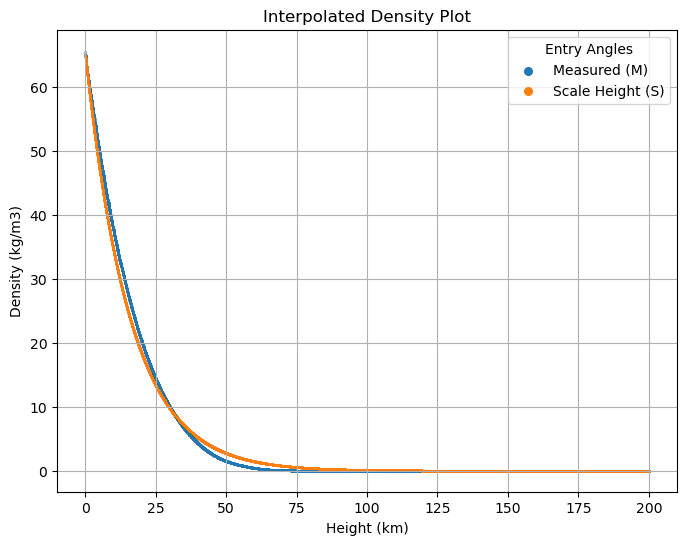

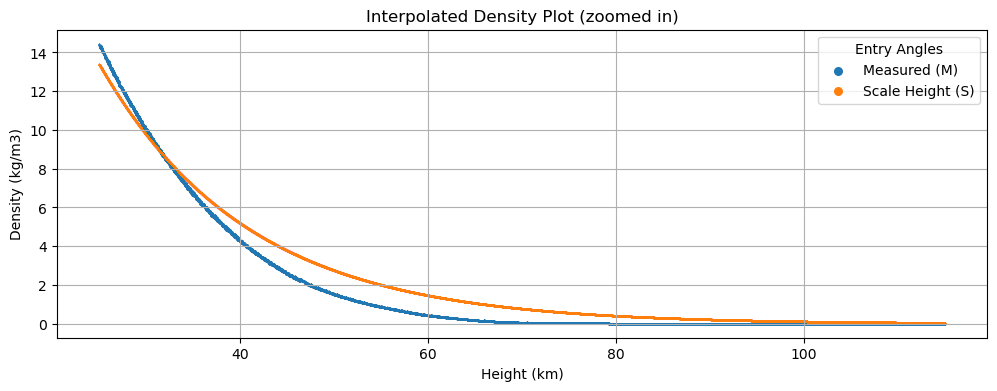

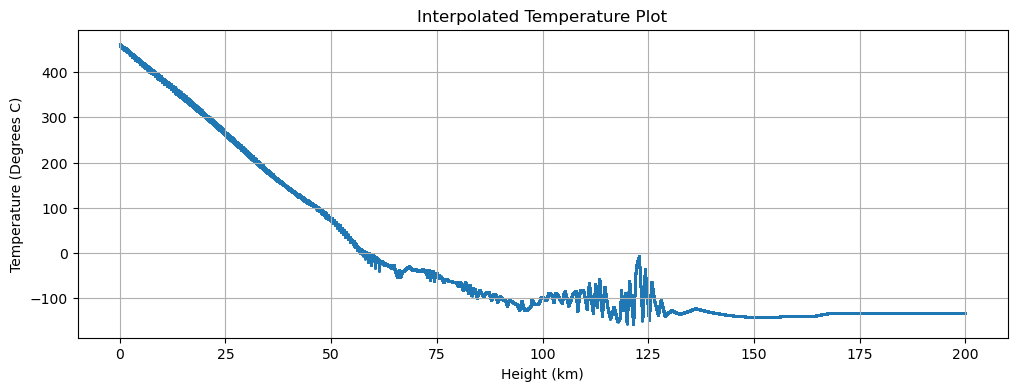

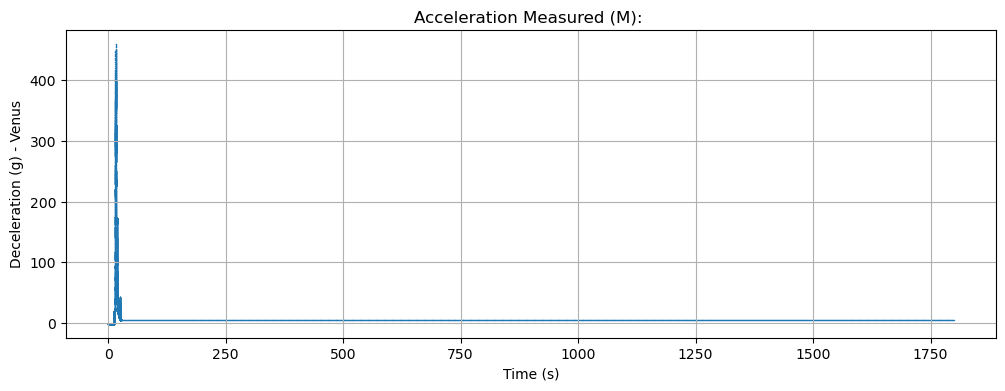

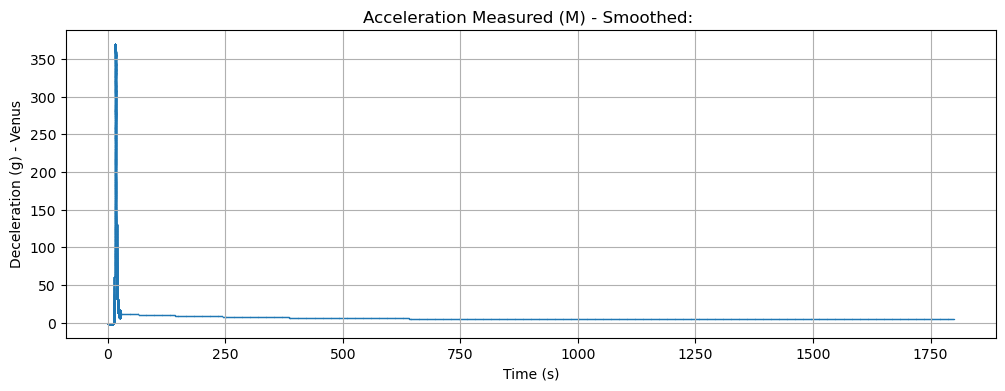

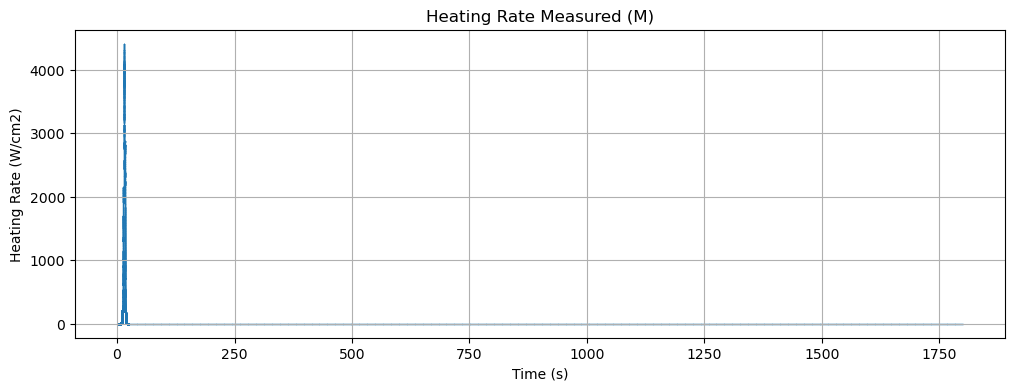

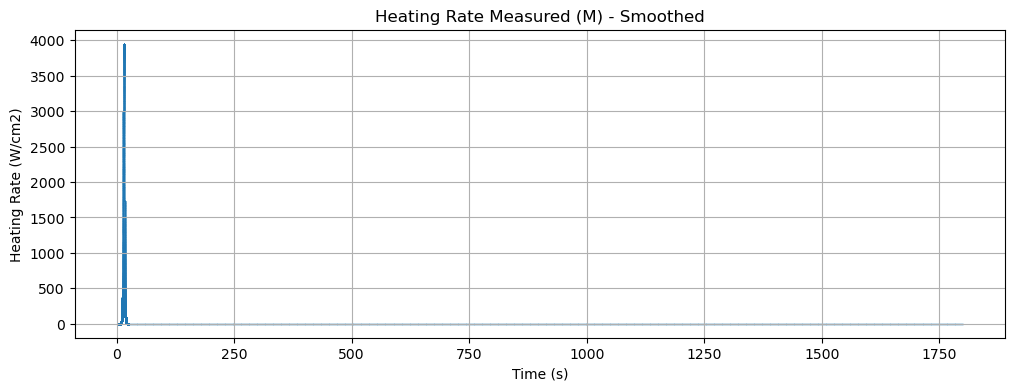

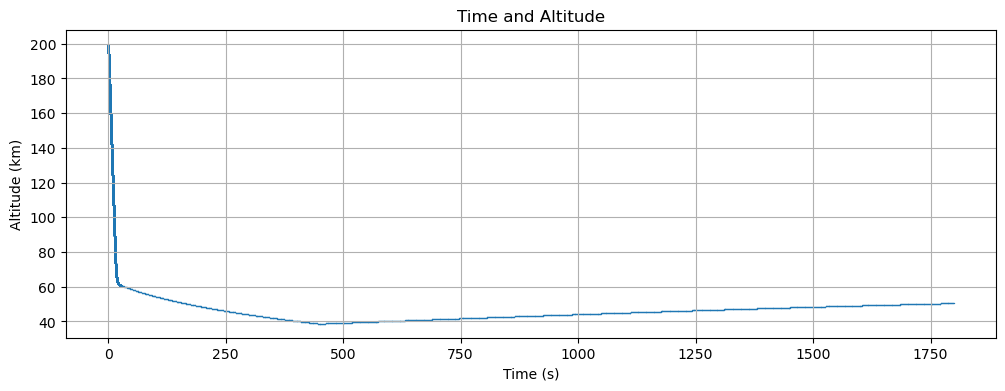

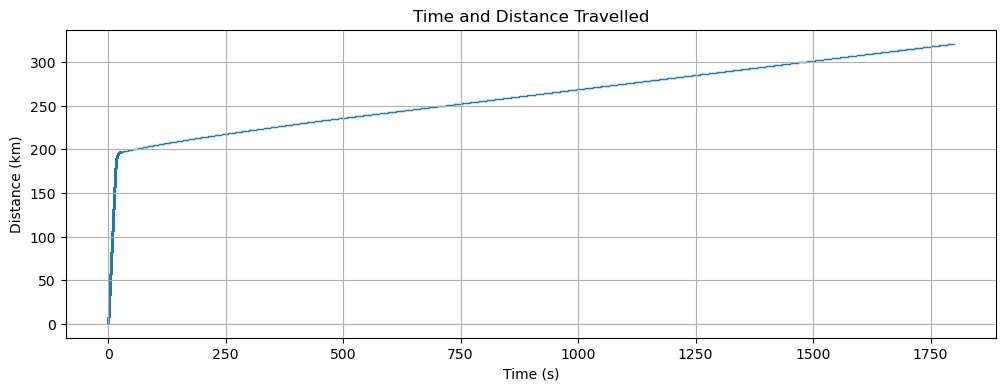

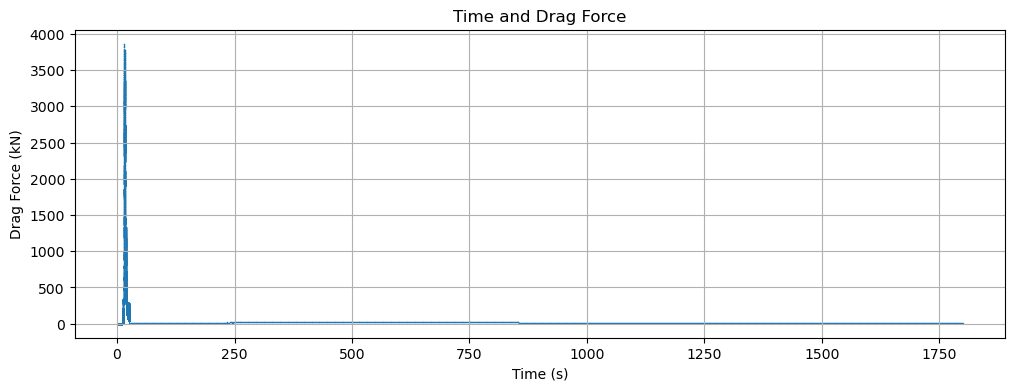

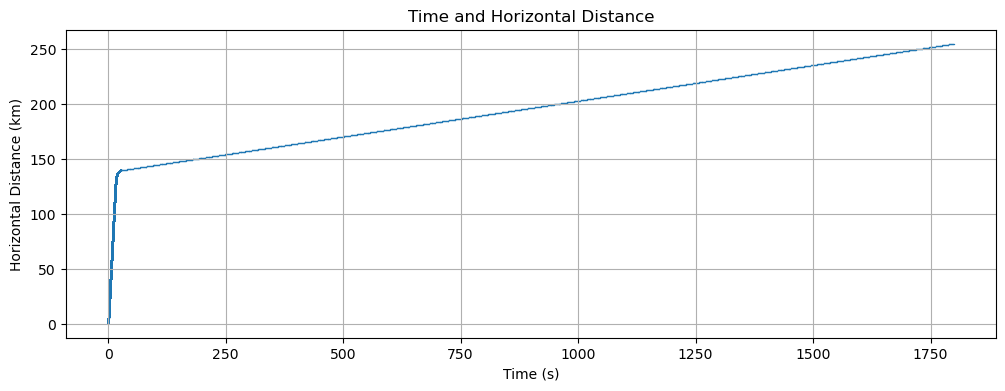

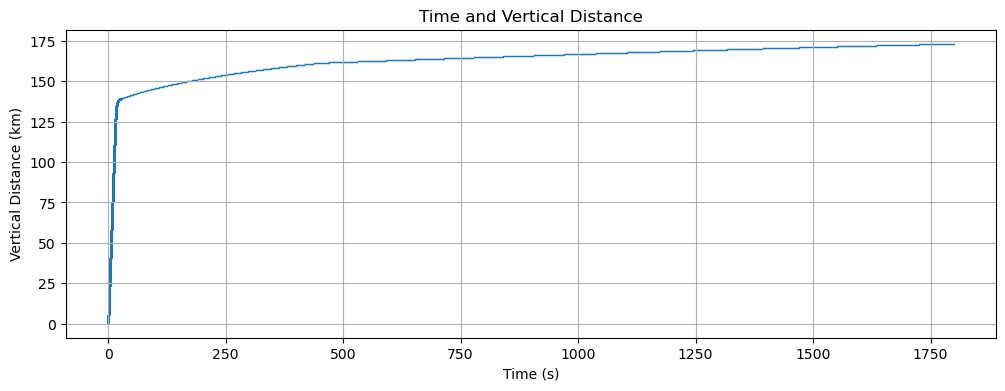

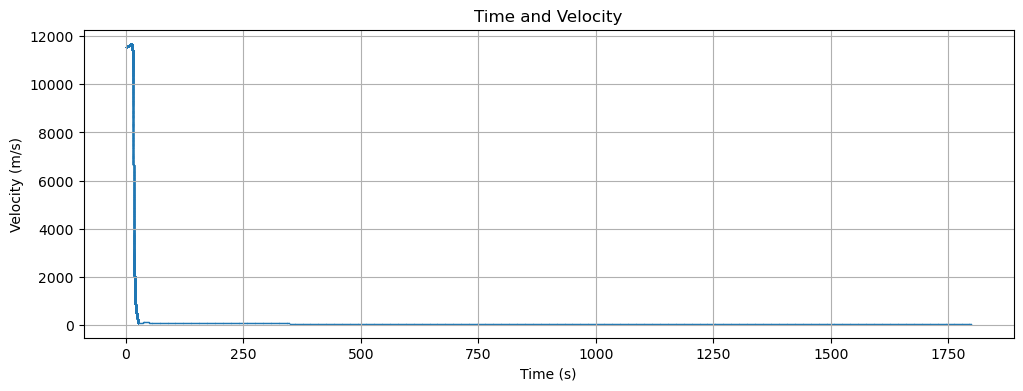

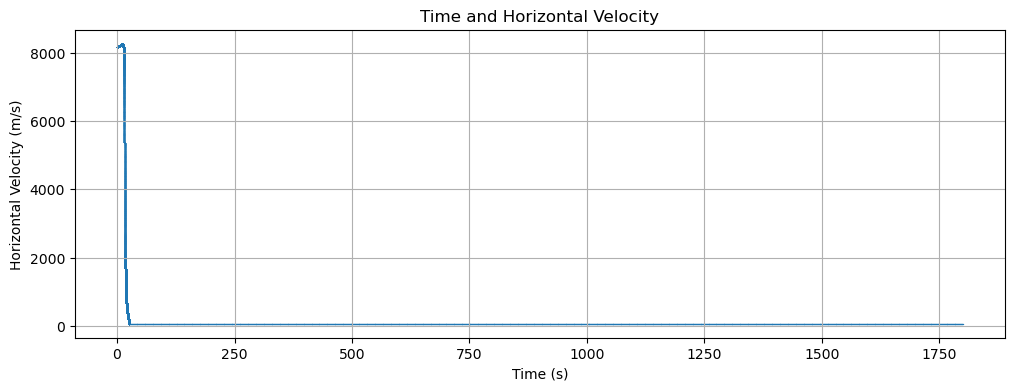

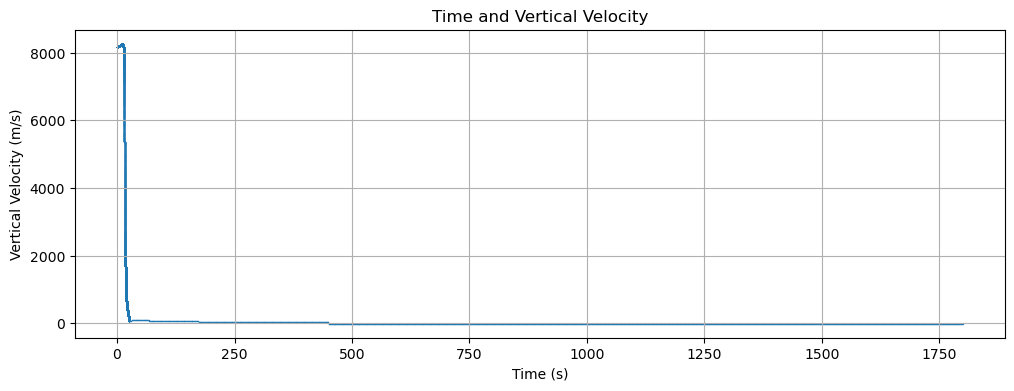

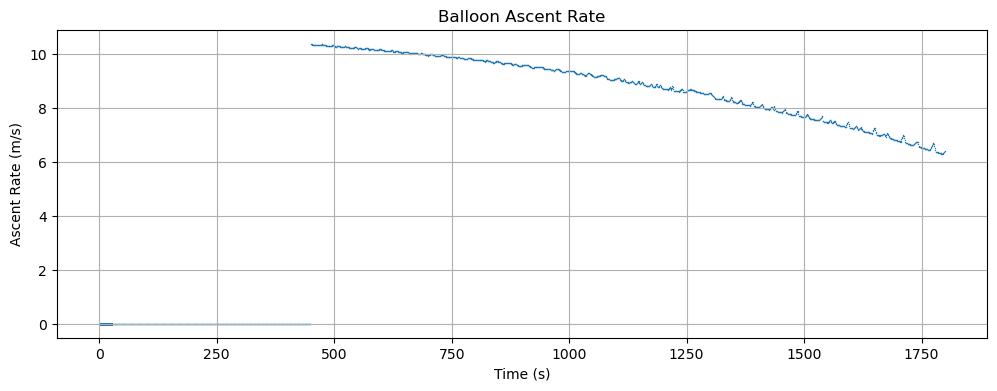

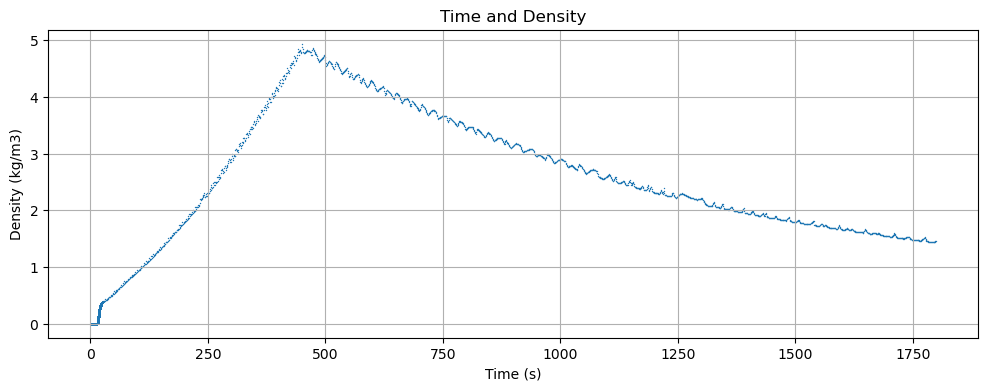

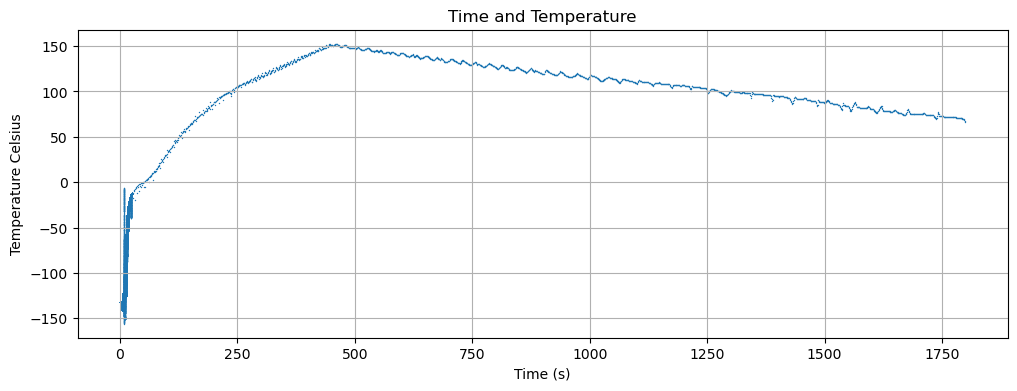

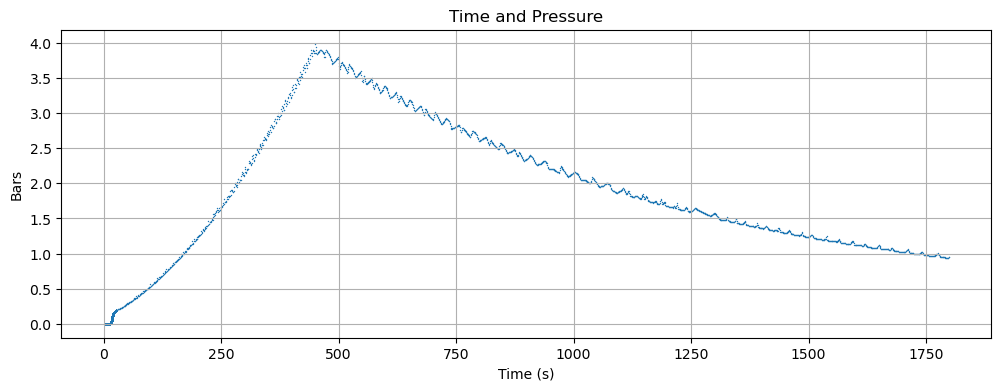

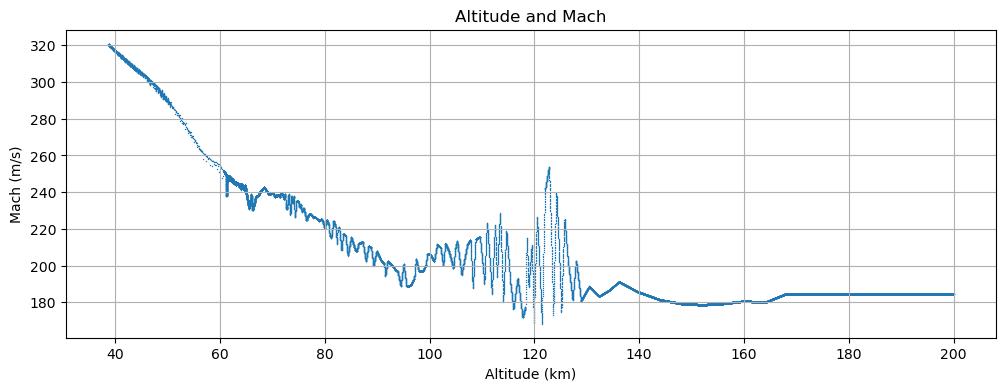

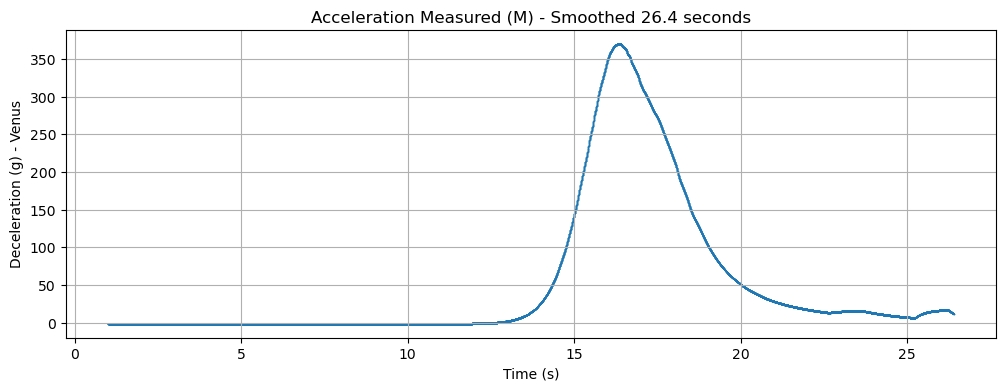

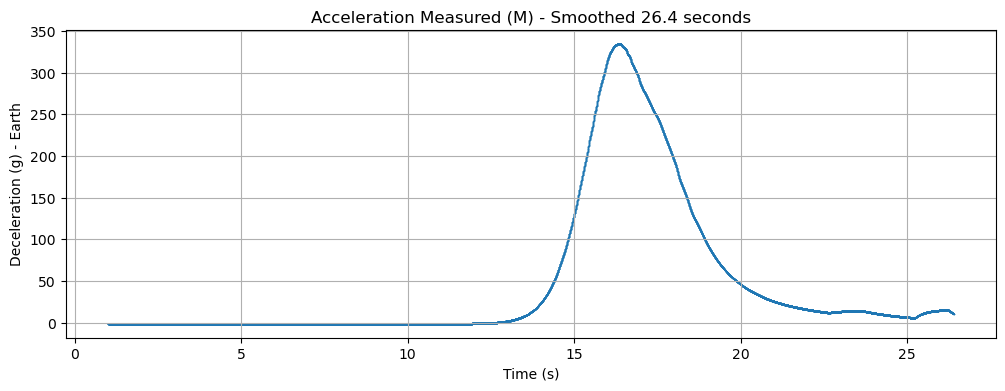

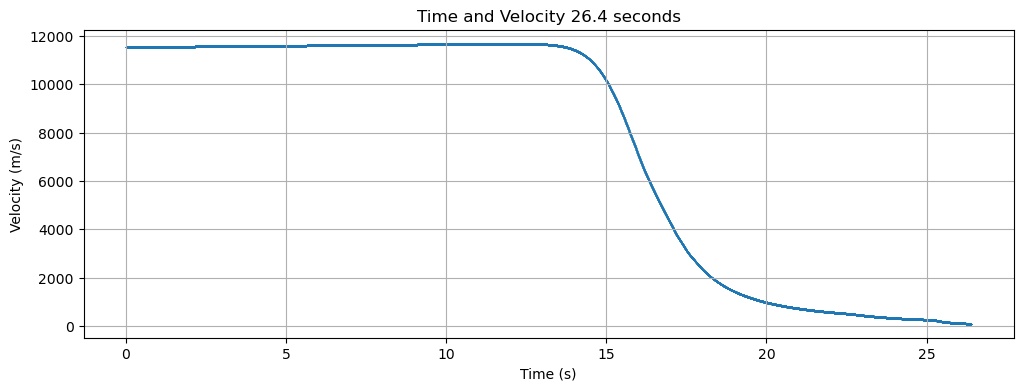

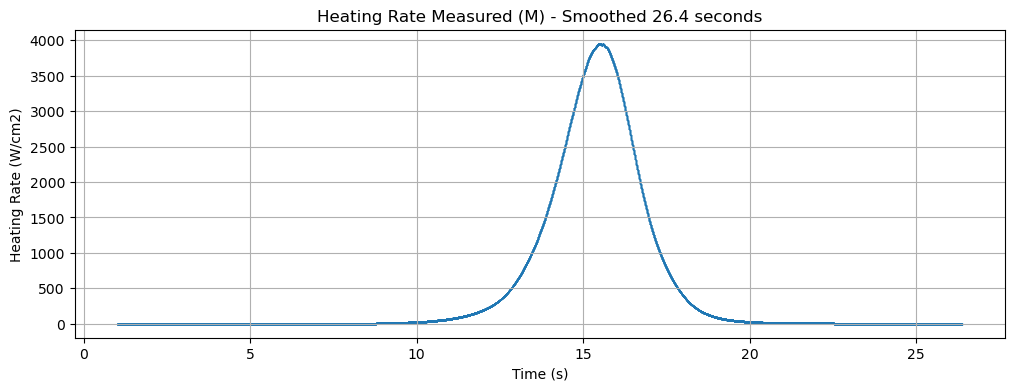

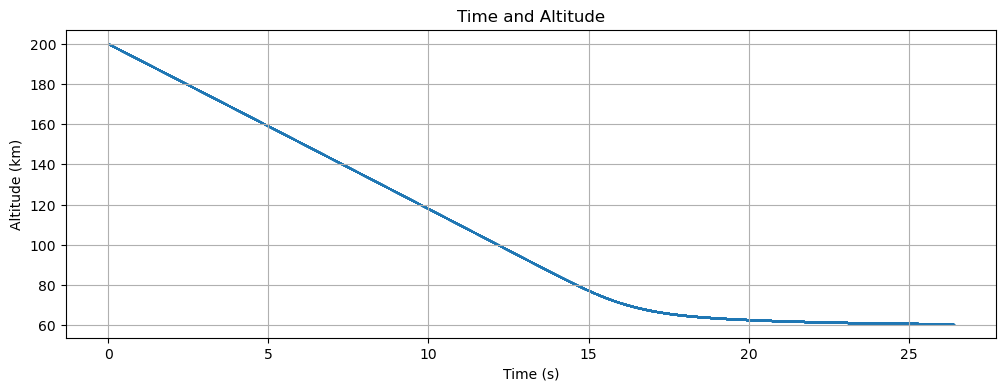


==========================================END OF SCRIPT===========================================



In [2]:
print("")
print("============================================STORE MODEL===========================================")
print("")    
    
#Convert back to km
dfA['ALT-KM'] = dfA['ALT-KM'] / 1000.0
dfT['ALT-KM'] = dfT['ALT-KM'] / 1000.0

#Sort original data for plotting
dfA.sort_values("ALT-KM", ascending=True)
dfT.sort_values("ALT-KM", ascending=True)

#Plot in seconds
dfStepModel['TimeMS'] = dfStepModel['TimeMS'] / StepResolutionOut

#Convert to correct units 
dfStepModel['Drag'] = dfStepModel['Drag'] / StepResolutionOut

#Convert to g [Venus]
dfStepModel['Acc'] = dfStepModel['Acc'] / g  

#store the model
tempfilesdirectory = r'C:\Users\stuar\OneDrive\Open University\SXS841\Venus Entry Modelling'
EntryStepModel = tempfilesdirectory + r'\entrystepmodel.csv'
dfStepModel.to_csv(EntryStepModel, index=False)

#Smooth the y-values, for plotting purposes only
smooth_yg = dfStepModel['Acc'].squeeze()
smooth_yg = smooth_yg.rolling(window=1000).mean()

#Smooth the y-values, for plotting purposes only    
smooth_yh = dfStepModel['qDot'].squeeze()
smooth_yh = smooth_yh.rolling(window=1000).mean() 

print("")
print("===============================================PLOTS==============================================")
print("")    

#Set plot size
plt.figure(figsize=(8, 6))
    
#Plot the density model
plt.scatter(densityX / StepResolutionOut, densityY, s=0.01, label='Measured (M)')
plt.scatter(densityX / StepResolutionOut, densityY2, s=0.01, label='Scale Height (S)')
plt.title('Interpolated Density Plot')
plt.xlabel('Height (km)')
plt.ylabel('Density (kg/m3)')
plt.grid(True)
lgnd = plt.legend(loc='upper right', title="Entry Angles", scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_DensityInterpolated.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12, 4))

#Plot the density model
plt.scatter(densityX[25000:115000:1] / StepResolutionOut, densityY[25000:115000:1], s=0.01, label='Measured (M)')
plt.scatter(densityX[25000:115000:1] / StepResolutionOut, densityY2[25000:115000:1], s=0.01, label='Scale Height (S)')
plt.title('Interpolated Density Plot (zoomed in)')
plt.xlabel('Height (km)')
plt.ylabel('Density (kg/m3)')
plt.grid(True)
lgnd = plt.legend(loc='upper right', title="Entry Angles", scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_DensityInterpolatedZoom.png',dpi=300, bbox_inches='tight') 
plt.show()


#Set plot size
plt.figure(figsize=(12,4))
    
#Plot the temp model
plt.scatter(tempX / 1000.0, tempY, s=1.0)
plt.title('Interpolated Temperature Plot')
plt.xlabel('Height (km)')
plt.ylabel('Temperature (Degrees C)')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_TempInterpolated.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

#Plot the acceleration in g in seconds
plt.scatter(dfStepModel['TimeMS'],dfStepModel['Acc'], s=1.0, linewidth=0)
if UseMeasurements == True:
    plt.title('Acceleration Measured (M): ')
else:
    plt.title('Acceleration Numerical Scale Height (S): ')
plt.xlabel('Time (s)')
plt.ylabel('Deceleration (g) - Venus')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_Acc.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

#Plot the acceleration in g in seconds
plt.scatter(dfStepModel['TimeMS'],smooth_yg, s=1.0, linewidth=0)
if UseMeasurements == True:
    plt.title('Acceleration Measured (M) - Smoothed: ')
else:
    plt.title('Acceleration Numerical Scale Height (S) - Smoothed: ')
plt.xlabel('Time (s)')
plt.ylabel('Deceleration (g) - Venus')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_Acc_Smoothed.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

#Plot the heating rate in W/cm2 per second
plt.scatter(dfStepModel['TimeMS'],dfStepModel['qDot'], s=1.0, linewidth=0)
if UseMeasurements == True:
    plt.title('Heating Rate Measured (M)')
else:
    plt.title('Heating Rate Numerical Scale Height (S)')
plt.xlabel('Time (s)')
plt.ylabel('Heating Rate (W/cm2)')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_qDot.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

#Plot the heating rate in W/cm2 per second
plt.scatter(dfStepModel['TimeMS'],smooth_yh, s=1.0, linewidth=0)
if UseMeasurements == True:
    plt.title('Heating Rate Measured (M) - Smoothed')
else:
    plt.title('Heating Rate Numerical Scale Height (S) - Smoothed')
plt.xlabel('Time (s)')
plt.ylabel('Heating Rate (W/cm2)')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_qDot_Smoothed.png',dpi=300, bbox_inches='tight') 
plt.show()    

#Set plot size
plt.figure(figsize=(12,4))

#Plot the step model elemnents
plt.scatter(dfStepModel['TimeMS'],dfStepModel['Alt'] / 1000.0, s=1.0, linewidth=0)
plt.title('Time and Altitude')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (km)')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_Alt.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

plt.scatter(dfStepModel['TimeMS'],dfStepModel['AngleD'] / 1000.0, s=1.0, linewidth=0)
plt.title('Time and Distance Travelled')
plt.xlabel('Time (s)')
plt.ylabel('Distance (km)')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_AngleD.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

plt.scatter(dfStepModel['TimeMS'],dfStepModel['Drag'], s=1.0, linewidth=0)
plt.title('Time and Drag Force')
plt.xlabel('Time (s)')
plt.ylabel('Drag Force (kN)')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_Drag.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

plt.scatter(dfStepModel['TimeMS'],dfStepModel['HorizontalD'] / 1000.0, s=1.0, linewidth=0)
plt.title('Time and Horizontal Distance')
plt.xlabel('Time (s)')
plt.ylabel('Horizontal Distance (km)')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_HorizontalD.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

plt.scatter(dfStepModel['TimeMS'],dfStepModel['VerticalD'] / 1000.0, s=1.0, linewidth=0)
plt.title('Time and Vertical Distance')
plt.xlabel('Time (s)')
plt.ylabel('Vertical Distance (km)')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_VerticalD.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

plt.scatter(dfStepModel['TimeMS'],dfStepModel['Velocity'], s=1.0, linewidth=0)
plt.title('Time and Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_Velocity.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

plt.scatter(dfStepModel['TimeMS'],dfStepModel['HorizontalV'], s=1.0, linewidth=0)
plt.title('Time and Horizontal Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Horizontal Velocity (m/s)')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_HorizontalV.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

plt.scatter(dfStepModel['TimeMS'],dfStepModel['VerticalV'], s=1.0, linewidth=0)
plt.title('Time and Vertical Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Vertical Velocity (m/s)')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_VerticalV.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

plt.scatter(dfStepModel['TimeMS'],dfStepModel['AscentRate'], s=1.0, linewidth=0)
plt.title('Balloon Ascent Rate')
plt.xlabel('Time (s)')
plt.ylabel('Ascent Rate (m/s)')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_AscentRate.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

plt.scatter(dfStepModel['TimeMS'],dfStepModel['Density'], s=1.0, linewidth=0)
plt.title('Time and Density')
plt.xlabel('Time (s)')
plt.ylabel('Density (kg/m3)')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_Density.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

plt.scatter(dfStepModel['TimeMS'],dfStepModel['Temperature'], s=1.0, linewidth=0)
plt.title('Time and Temperature')
plt.xlabel('Time (s)')
plt.ylabel('Temperature Celsius')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_Temperature.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

plt.scatter(dfStepModel['TimeMS'],dfStepModel['Pressure'], s=1.0, linewidth=0)
plt.title('Time and Pressure')
plt.xlabel('Time (s)')
plt.ylabel('Bars')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_Pressure.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

plt.scatter(dfStepModel['Alt'] / 1000.0,dfStepModel['Mach'], s=1.0, linewidth=0)
plt.title('Altitude and Mach')
plt.xlabel('Altitude (km)')
plt.ylabel('Mach (m/s)')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_Mach.png',dpi=300, bbox_inches='tight') 
plt.show()

#Plot the model elements for the 1st 26.4 seconds before balloon inflation to capture the ballistic entry
#and parachute opening events

#Set plot size
plt.figure(figsize=(12,4))

subrange_time = pd.DataFrame()
subrange_time['Time'] = dfStepModel.loc[0:26400, ['TimeMS']]
subrange_time['g'] = smooth_yg[0:26400:1]
plt.scatter(subrange_time['Time'],subrange_time['g'], s=1.0, linewidth=0)
if UseMeasurements == True:
    plt.title('Acceleration Measured (M) - Smoothed 26.4 seconds')
else:
    plt.title('Acceleration Numerical Scale Height (S) - Smoothed 26.4 seconds')
plt.xlabel('Time (s)')
plt.ylabel('Deceleration (g) - Venus')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_Acc_Smoothed264.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

subrange_time['g'] = subrange_time['g'] * (g / gE)
plt.scatter(subrange_time['Time'],subrange_time['g'], s=1.0, linewidth=0)
if UseMeasurements == True:
    plt.title('Acceleration Measured (M) - Smoothed 26.4 seconds')
else:
    plt.title('Acceleration Numerical Scale Height (S) - Smoothed 26.4 seconds')
plt.xlabel('Time (s)')
plt.ylabel('Deceleration (g) - Earth')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_Acc_Smoothed264.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

subrange_time['Velocity'] = dfStepModel.loc[0:26400, ['Velocity']]
plt.scatter(subrange_time['Time'],subrange_time['Velocity'], s=1.0, linewidth=0)
plt.title('Time and Velocity 26.4 seconds')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_Velocity264.png',dpi=300, bbox_inches='tight') 
plt.show()

#Set plot size
plt.figure(figsize=(12,4))

subrange_time['QDot'] = smooth_yh[0:26400:1]
plt.scatter(subrange_time['Time'],subrange_time['QDot'], s=1.0, linewidth=0)
if UseMeasurements == True:
    plt.title('Heating Rate Measured (M) - Smoothed 26.4 seconds') 
else:
    plt.title('Heating Rate Scale Height (S) - Smoothed 26.4 seconds') 
plt.xlabel('Time (s)')
plt.ylabel('Heating Rate (W/cm2)')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_qDot_Smoothed264.png',dpi=300, bbox_inches='tight') 
plt.show()    

#Set plot size
plt.figure(figsize=(12,4))

subrange_time['Alt'] = dfStepModel.loc[0:26400, ['Alt']]
plt.scatter(subrange_time['Time'],subrange_time['Alt'] / 1000.0, s=1.0, linewidth=0)
plt.title('Time and Altitude')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (km)')
plt.grid(True)
plt.savefig(tempfilesdirectory + r'\Model_VAL_Probe_Alt264.png',dpi=300, bbox_inches='tight') 
plt.show()

print("")
print("==========================================END OF SCRIPT===========================================")
print("")   